In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, \
multilabel_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

# Exploring Multi-label text classification with Machine Learning

## What is Multi-label classification

There are mainly tree types of classification problems:
    
    Bynary classification puts the samples in only one of two possible classes. A person can be either a male or a female.

    Multiclass classification means a classification task with more than two classes; e.g., classify a set of people in different age groups. Multiclass classification makes the assumption that each sample is assigned to one and only one label: a person can only be between 20 and 29 years old or 30 to 39 years old but not in both groups.
    
    Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A text might be about any of religion, politics, finance or education at the same time or none of these.

There are two main methods for tackling a multi-label classification problem: problem transformation methods and algorithm adaptation methods.
Problem transformation methods transform the multi-label problem into a set of binary classification problems, which can then be handled using single-class classifiers. They include OneVsRest and Binary Relevance techniques.

Whereas algorithm adaptation methods adapt the algorithms to directly perform multi-label classification. In other words, rather than trying to convert the problem to a simpler problem, they try to address the problem in its full form. They include Classifier Chains, Label Powerset and Adapted Algorithm.

## Our dataset

We will use the datasets from a Kaggle competition which aims to resolve the problem with negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). The dataset contains a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are: **toxic, severe_toxic,obscene, threat, insult,identity_hate**. A model which predicts a probability of each type of toxicity for each comment must be created.

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview

First we load our files:

In [3]:
train_set = pd.read_csv('./data/train.csv')
test_set = pd.read_csv('./data/test.csv')
test_labels = pd.read_csv('./data/test_labels.csv')

In [4]:
print('train set', train_set.head(10))
print('test set', test_set.head(10))
print('test labels', test_labels.head(10))

train set                  id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
5  00025465d4725e87  "\n\nCongratulations from me as well, use the ...      0   
6  0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1   
7  00031b1e95af7921  Your vandalism to the Matt Shirvington article...      0   
8  00037261f536c51d  Sorry if the word 'nonsense' was offensive to ...      0   
9  00040093b2687caa  alignment on this subject and which are contra...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0

## Data cleaning and analisys

We need to check for empty values just in case:

In [ ]:
print(train_set.isna().sum())
print(test_set.isna().sum())
print(test_labels.isna().sum())

As it was a competition, to deter hand labeling, the test_set contains some comments which are not included 
in scoring. We need to remove the comments containing labels with -1 from the later supplied test_labels file and the test_set.

In [5]:
test_set = test_set[test_labels['toxic'] != -1]
test_labels = test_labels[test_labels['toxic'] != -1]
test_features = test_set.comment_text
train_features = train_set.comment_text
print('test labels', test_labels.head(10))
train_labels = train_set.drop(['id', 'comment_text'], axis = 1)
test_labels = test_labels.drop(['id'], axis = 1)
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

test labels                   id  toxic  severe_toxic  obscene  threat  insult  \
5   0001ea8717f6de06      0             0        0       0       0   
7   000247e83dcc1211      0             0        0       0       0   
11  0002f87b16116a7f      0             0        0       0       0   
13  0003e1cccfd5a40a      0             0        0       0       0   
14  00059ace3e3e9a53      0             0        0       0       0   
16  000663aff0fffc80      0             0        0       0       0   
17  000689dd34e20979      0             0        0       0       0   
19  000844b52dee5f3f      0             0        0       0       0   
21  00091c35fa9d0465      1             0        0       0       0   
22  000968ce11f5ee34      0             0        0       0       0   

    identity_hate  
5               0  
7               0  
11              0  
13              0  
14              0  
16              0  
17              0  
19              0  
21              0  
22              0

We want to try to clean the text of the comments by removing punctuation and spcial characters, converting all to lowercase, stripping white space, and replacing some commonly used short forms with their full words. We want save the cleaned comments in separate variables and test the vectorizer algorithm with both sets. We will also use the stop_words parameter of the vectorizer algorithm to remove the words that do not bring value and will actually confuse and slow down the vectorizer.

In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

test_features_cleaned = test_features.map(lambda com : clean_text(com))
train_features_cleaned = train_features.map(lambda com : clean_text(com))

We check the percentage of labeled and non-labeled comments

In [8]:
print('Percentage of comments without labels: ')
print(len((train_set[(train_set.toxic == 0) & (train_set.severe_toxic == 0) & (train_set.obscene == 0) & (train_set.insult == 0) & (train_set.insult == 0) & (train_set.identity_hate == 0)])) / len(train_set)*100)
print('Percentage of comments with one or more labels: ')
print(len(train_set[(train_set.toxic == 1) | (train_set.severe_toxic == 1) | (train_set.obscene == 1) | (train_set.insult == 1) | (train_set.insult == 1) | (train_set.identity_hate == 1)]) / len(train_set)*100)

Percentage of comments without labels: 
89.84589931754516
Percentage of comments with one or more labels: 
10.154100682454832


In [9]:
test_labels.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000
mean,0.095189,0.005736,0.057692,0.003298,0.053565,0.011129
std,0.293478,0.075522,0.233161,0.057334,0.225160,0.104905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Count the number of comments per label

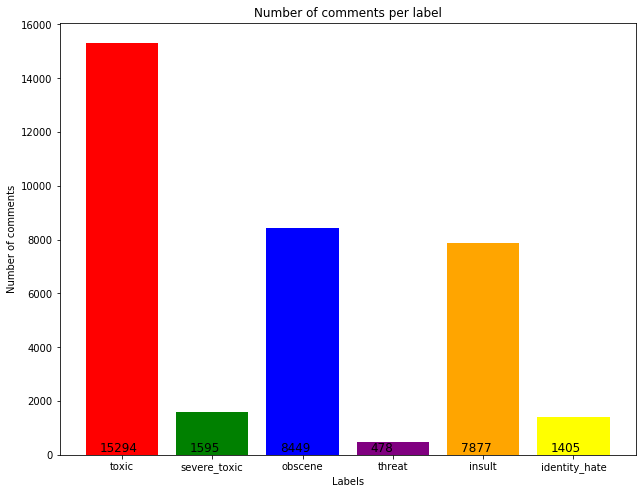

In [17]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
total_count = []
for label in labels:
    total_count.append(len(train_labels[train_labels[label] == 1]))
ax.bar(labels,total_count, color=['red', 'green', 'blue', 'purple', 'orange', 'yellow'])
for i,data in enumerate(total_count):
    plt.text(i-.25, 
              data/total_count[i]+100, 
              total_count[i], 
              fontsize=12)
plt.title('Number of comments per label')
plt.xlabel('Labels')
plt.ylabel('Number of comments')

plt.show()

For our purpose we are going to use OneVsRest classifier as the others are more complex and would take a considerable amount of time. OneVsRest classifier basically takes a classifier algorithm as a parameter and uses it to do a binary classification for each label in the dataset. We will also use pipelines to streamline the process by adding all estimators we need to be executed one after anoter. As the content we are going to analise is text we need first convert it into numeric values in order for our model to be able to process it. This is done by vectorizer algorithms that use different methods for comparing and weighing the relation between words in a single document and their relations in the whole corpus. They first collect all the unique words in a document(comment in our case) and build a dictionary of them and then vectorise each one giving it a specific weigth based on how much a word relates to a specific label within the whole corpus(the collection of all comments in our dataset). We are going to use TfidfVectorizer which is one of the widely used vectorisers.

## Creating baseline models

In order to choose our best classifier and improve it further we are going to test tree different classifiers - **NaiveBayes, LogisticRegression and SVM with linear kernel** using their default parameters. 
    
The еvaluation metrics we are going to use to judge our models :
    
    As specified in the competition requirements we need to use AUC. 
    
    As suggested in some other articles we will also use micro-averaging for all labels of precision, recall and F1-score
    
LinearSVM algorithm does not have a predict_proba method which makes it impossible to use roc_auc_score for this model. I tried with SVC(kernel='linear',probability=True) which should make it possible but it took forever to compute so I just had to abandon it. We will just use acuracy_score and micro_averages F1-score.

In [34]:
NB_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                       ('nb_model', OneVsRestClassifier(MultinomialNB(), n_jobs=-1))])

LR_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                       ('lr_model', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))])

# SVM_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
#                        ('svm_model', OneVsRestClassifier(SVC(kernel='linear',probability=True)))])

SVM_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                       ('svm_model', OneVsRestClassifier(LinearSVC(), n_jobs=-1))])

def plot_roc_curve(test_features, predict_prob):
    fpr, tpr, thresholds = roc_curve(test_features, predict_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve for toxic comments')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(labels)

def run_pipeline(pipeline, train_feats, train_lbls, test_feats, test_lbls):
    pipeline.fit(train_feats, train_labels)
    predictions = pipeline.predict(test_feats)
    pred_proba = pipeline.predict_proba(test_feats)
    print('roc_auc: ', roc_auc_score(test_lbls, pred_proba))
    print('accuracy: ', accuracy_score(test_lbls, predictions))
    print('confusion matrices: ')
    print(multilabel_confusion_matrix(test_lbls, predictions))
    print('classification_report: ')
    print(classification_report(test_lbls, predictions, target_names=labels))
    
def run_SVM_pipeline(pipeline, train_feats, train_lbls, test_feats, test_lbls):
    pipeline.fit(train_feats, train_labels)
    predictions = pipeline.predict(test_feats)
    print('accuracy: ', accuracy_score(test_lbls, predictions))
    print('confusion matrices: ')
    print(multilabel_confusion_matrix(test_lbls, predictions))
    print('classification_report: ')
    print(classification_report(test_lbls, predictions, target_names=labels))
    
def plot_pipeline_roc_curve(pipeline, train_feats, train_lbls, test_feats, test_lbls):
    for label in labels:
        pipeline.fit(train_feats, train_set[label])
        pred_proba = pipeline.predict_proba(test_feats)[:,1]
        plot_roc_curve(test_lbls[label], pred_proba)


In [18]:
run_pipeline(NB_pipeline, train_features, train_labels, test_features, test_labels)

roc_auc:  0.8492331250708368
accuracy:  0.9030135359029666
confusion matrices: 
[[[57731   157]
  [ 4749  1341]]

 [[63611     0]
  [  367     0]]

 [[60256    31]
  [ 3218   473]]

 [[63767     0]
  [  211     0]]

 [[60517    34]
  [ 3245   182]]

 [[63266     0]
  [  712     0]]]
classification_report: 
               precision    recall  f1-score   support

        toxic       0.90      0.22      0.35      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.94      0.13      0.23      3691
       threat       0.00      0.00      0.00       211
       insult       0.84      0.05      0.10      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.90      0.14      0.24     14498
    macro avg       0.45      0.07      0.11     14498
 weighted avg       0.81      0.14      0.23     14498
  samples avg       0.02      0.01      0.01     14498



In [19]:
run_pipeline(LR_pipeline, train_features, train_labels, test_features, test_labels)

roc_auc:  0.9750817379473767
accuracy:  0.8976523179843071
confusion matrices: 
[[[55722  2166]
  [ 1894  4196]]

 [[63431   180]
  [  247   120]]

 [[59560   727]
  [ 1448  2243]]

 [[63727    40]
  [  168    43]]

 [[59903   648]
  [ 1705  1722]]

 [[63200    66]
  [  546   166]]]
classification_report: 
               precision    recall  f1-score   support

        toxic       0.66      0.69      0.67      6090
 severe_toxic       0.40      0.33      0.36       367
      obscene       0.76      0.61      0.67      3691
       threat       0.52      0.20      0.29       211
       insult       0.73      0.50      0.59      3427
identity_hate       0.72      0.23      0.35       712

    micro avg       0.69      0.59      0.63     14498
    macro avg       0.63      0.43      0.49     14498
 weighted avg       0.69      0.59      0.63     14498
  samples avg       0.06      0.05      0.05     14498



In [16]:
# run_pipeline(SVM_pipeline, train_features, train_labels, test_features, test_labels)
run_SVM_pipeline(SVM_pipeline, train_features, train_labels, test_features, test_labels)

accuracy:  0.8813654693800994
confusion matrices: 
[[[54444  3444]
  [ 1306  4784]]

 [[63396   215]
  [  237   130]]

 [[59102  1185]
  [ 1138  2553]]

 [[63697    70]
  [  150    61]]

 [[59625   926]
  [ 1487  1940]]

 [[63146   120]
  [  488   224]]]
classification_report: 
               precision    recall  f1-score   support

        toxic       0.58      0.79      0.67      6090
 severe_toxic       0.38      0.35      0.37       367
      obscene       0.68      0.69      0.69      3691
       threat       0.47      0.29      0.36       211
       insult       0.68      0.57      0.62      3427
identity_hate       0.65      0.31      0.42       712

    micro avg       0.62      0.67      0.64     14498
    macro avg       0.57      0.50      0.52     14498
 weighted avg       0.63      0.67      0.64     14498
  samples avg       0.07      0.06      0.06     14498



Plot ROC curve for LogisticRegression model

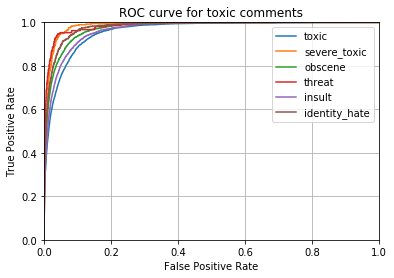

In [31]:
plot_pipeline_roc_curve(LR_pipeline, train_features, train_labels, test_features, test_labels)

Plot ROC curve for NaiveBayes model

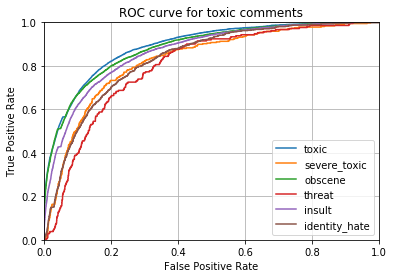

In [21]:
plot_pipeline_roc_curve(NB_pipeline, train_features, train_labels, test_features, test_labels)

## Hyperparameter tunning

We select the LogisticRegression classifier as our best and will try to improve our results with the following techniques:
    improve the tf-idf vectorizer's parameters
    improve the tf-idf vectorizer by cleaning the text of the comments
    improve the logistic regression's parameters
    
We checked the distribution of samples in our dataset earlier and we saw that it was highly unbalanced - 90% features with no labels and 10% features with one or more labels.
In this situation in case of bynary or multiclass classification we would be able to use GridSearch with StratifiedKFold cross validation splits to test a set of different parameters for every algorithm in our pipeline. In our case though, the StratifiedKFold does not suppport multi-label and using just KFold would not yeld any useful data splits. I decided to give it a try anyway to prove this or burst it. 

In [ ]:
# TAKES ABOUT 40min to run
# alpha = [0.1,1,10]
# penalty=['l1','l2']
# n_gram=[(1,1),(1,2)]
# param_grid = {
#     'tfidf__ngram_range': n_gram,
#     'lr_model__estimator__C': alpha
# }
# gsearch_cv = GridSearchCV(LR_pipeline, param_grid=param_grid, cv=5)
# gsearch_cv.fit(train_features, train_labels)

In [ ]:
gsearch_cv.best_score_
# 0.919784923325667

In [ ]:
gsearch_cv.best_params_
# {'lr_model__estimator__C': 10, 'tfidf__ngram_range': (1, 2)}

In [32]:
LR_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
                       ('lr_model', OneVsRestClassifier(LogisticRegression(C=10), n_jobs=-1))])

In [33]:
run_pipeline(LR_pipeline, train_features, train_labels, test_features, test_labels)

roc_auc:  0.9754610987629123
accuracy:  0.88294413704711
confusion matrices: 
[[[54463  3425]
  [ 1305  4785]]

 [[63264   347]
  [  191   176]]

 [[58931  1356]
  [ 1034  2657]]

 [[63657   110]
  [  132    79]]

 [[59296  1255]
  [ 1241  2186]]

 [[63045   221]
  [  392   320]]]
classification_report: 
               precision    recall  f1-score   support

        toxic       0.58      0.79      0.67      6090
 severe_toxic       0.34      0.48      0.40       367
      obscene       0.66      0.72      0.69      3691
       threat       0.42      0.37      0.40       211
       insult       0.64      0.64      0.64      3427
identity_hate       0.59      0.45      0.51       712

    micro avg       0.60      0.70      0.65     14498
    macro avg       0.54      0.57      0.55     14498
 weighted avg       0.61      0.70      0.65     14498
  samples avg       0.07      0.07      0.06     14498



Running the pipeline with the suggested best parameters actually resulted in getting a better AUC accuracy. My asumption is that it was just by chance as there is no way to do a proper training on such an inbalanced set without stratifying the folds. We will proceed with a manual tunning of the models' parameters anyway to make a comparison.

**We try the cleaned comments with the default parameters used for our baseline best model and see almost no difference, a slight decrease in fact with 0.0001:**

with cleaned comments and C=1, ngram_range=(1,1) - roc_auc:  0.9750820030803234
micro avg       0.69      0.59      0.63     14498

**Second thing we try to increase n-gram range of the tf-idf. n-gram parameter defines the number of consecutive words to be combined when creating the vectorising the text content. (1,1) is the default value which means only single words will be used**

with not cleaned comments and C=1, ngram_range=(1,2) - roc_auc:  0.9734608599958284 
micro avg       0.68      0.59      0.63     14498

with not cleaned comments and C=1, ngram_range=(2,2) - roc_auc:  0.8695484960212974
micro avg       0.86      0.08      0.15     14498

with not cleaned comments and C=1, ngram_range=(1,3) - roc_auc:  0.9721529511622968
micro avg       0.66      0.61      0.63     14498

**different values for LogisticRegression parameters
start with C wich is the regularization strength parameter - smaller values specify stronger regularization.**

with not cleaned comments and C=.5, ngram_range=(1,1) - roc_auc:  0.9739737234377395
micro avg       0.73      0.53      0.61     14498

with not cleaned comments and C=2, ngram_range=(1,1) - roc_auc:  0.9752981961370573
micro avg       0.67      0.63      0.64     14498

with not cleaned comments and C=3, ngram_range=(1,1) - roc_auc:  0.9749554220049567
micro avg       0.65      0.64      0.65     14498

with not cleaned comments and C=2.1, ngram_range=(1,1) - roc_auc:  0.9752756613723531
micro avg       0.66      0.63      0.65     14498

with not cleaned comments and C=1.9, ngram_range=(1,1) - roc_auc:  0.9753144853229717
micro avg       0.67      0.62      0.64     14498

**OUR BEST PARAMS**
**with cleaned comments and C=1.5, ngram_range=(1,1) - roc_auc:  0.9753254734889681
micro avg       0.67      0.62      0.64     14498**

with not cleaned comments and C=1.4, ngram_range=(1,1) - roc_auc:  0.9753073320518185
micro avg       0.67      0.62      0.64     14498

**We select C=1.5 to be the best value and then we lastly try the penalty parameter of 'l1' as the default is 'l2'**

with not cleaned comments and C=1.5, l1, ngram_range=(1,1) - roc_auc:  0.9725936377263187
micro avg       0.67      0.62      0.64     14498

In [ ]:
# change parameters manually to get the results above
LR_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
                       ('lr_model', OneVsRestClassifier(LogisticRegression(C=10), n_jobs=-1))])

In [ ]:
run_pipeline(LR_pipeline, train_features_cleaned, train_labels, test_features_cleaned, test_labels)

## Conclusion

Using relatively simple methods and algorithms we managed to create a model with an accuracy above 97% which is quite high.
We could not 100% prove that cross-validation is not applicable for multi-label classification problems. Probably we need to run GridSearchCV few more times to see if we will get always tha same results.
Using the created setup we can continue trying to improve our model by:

1. Performing different types of stemming of the words
2. Try other algorithms for vectorizing comments' content like word2vec
3. Try using character n-grams instead of word n-grams
4. Try using ensemble classification algorithms

## RESOURCES

1. https://en.wikipedia.org/wiki/Multi-label_classification

2. https://scikit-learn.org/stable/modules/multiclass.html

3. https://medium.com/@saugata.paul1010/a-detailed-case-study-on-multi-label-classification-with-machine-learning-algorithms-and-72031742c9aa

4. https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

5. https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
